In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
%matplotlib inline

import pandas as pd # data handling
import numpy as np # numerical computation packages in python
import cmath # for handling complex numbers
import matplotlib.pyplot as plt # plotting routines
from scipy.integrate import odeint # solving the system of differential equations
from scipy.optimize import root # finding fixed points
#import sympy # symbolic mathematics for analytic solutions

In [2]:
#PART 1- SOLVING NETWORK EQUATIONS

In [3]:
#1. Defining commonly used parameters

# Consumer/Generator vector. P_i = p if generator, P_i = -p if consumer
p = 1 # value used in Nonlocal failures paper
P = np.asarray([-p, p, p, p, -p, -p, p, -p])

# damping constant
alpha = np.asarray([p]*8) # value used in Nonlocal failures paper- see fig 4

# Adjacency matrix. K[i,j] = k if link exists between nodes i and j, K[i,j] = 0 otherwise
# Link (0,1) is equivalent to link (1,2) in diagram

k = 1.03*p # value used in Nonlocal failures paper- see fig 4
dk = k # value used in Nonlocal failures paper- see fig 4
K = np.asarray([[0, k, 0, 0, 0, k, k, 0], 
                [k, 0, k, dk, 0, 0, 0, 0], 
                [0, k, 0, k, 0, 0, k, 0],
                [0, dk, k, 0, k, 0, 0, k],
                [0, 0, 0, k, 0, k, 0, 0],
                [k, 0, 0, 0, k, 0, 0, k],
                [k, 0, k, 0, 0, 0, 0, 0],
                [0, 0, 0, k, 0, k, 0, 0]])

# control vector
c = 0.1 # value used in Curing Braess' Paradox paper- see fig 1
C = np.asarray([c]*8)

In [4]:
#2. System of equations describing the oscillator model
def oscillator_model(X, t, K, C, P, alpha):
    
    # i = node under consideration
    # j = coupled node
    
    # phi_0, ..., phi_7, omega_0, ..., omega_7  = X #unpacking state vector
    phi = np.asarray([X[0], X[1], X[2], X[3], X[4], X[5], X[6], X[7]])
    omega = np.asarray([X[8], X[9], X[10], X[11], X[12], X[13], X[14], X[15]])
    
    # preallocating vectors
    coupling = np.zeros((8,1))
    dphi = np.zeros((8,1))
    domega = np.zeros((8,1))
    
    # calculating coupling term of each omega equation
    for a in range(len(coupling)):
        for b in range(len(coupling)):
            coupling[a] = coupling[a] + K[a,b]*np.sin(phi[b]-phi[a])
      
    # system of equations to be solved
    dphi[0] = omega[0]
    dphi[1] = omega[1]
    dphi[2] = omega[2]
    dphi[3] = omega[3]
    dphi[4] = omega[4]
    dphi[5] = omega[5]
    dphi[6] = omega[6]
    dphi[7] = omega[7]
    domega[0] = - alpha[0]*omega[0] - C[0]*phi[0] + P[0] + coupling[0]
    domega[1] = - alpha[1]*omega[1] - C[1]*phi[1] + P[1] + coupling[1]
    domega[2] = - alpha[2]*omega[2] - C[2]*phi[2] + P[2] + coupling[2]
    domega[3] = - alpha[3]*omega[3] - C[3]*phi[3] + P[3] + coupling[3] 
    domega[4] = - alpha[4]*omega[4] - C[4]*phi[4] + P[4] + coupling[4]
    domega[5] = - alpha[5]*omega[5] - C[5]*phi[5] + P[5] + coupling[5]
    domega[6] = - alpha[6]*omega[6] - C[6]*phi[6] + P[6] + coupling[6]
    domega[7] = - alpha[7]*omega[7] - C[7]*phi[7] + P[7] + coupling[7]    
    
    # concatenating vectors into single solution vector
    dXdt = np.asarray([dphi, domega])
    dXdt = dXdt.reshape(16)
    
    return dXdt

In [5]:
#3. Use a package to solve the differential equation for 25 time units

#initial conditions x0=[phi_0, phi_1, ..., omega_0, omega_1, ...]
x0 = [.0]*16
t = np.linspace(0, 25, 100000) #time span
sol_1 = odeint(oscillator_model, x0, t, args=(K,C,P,alpha)) #solver

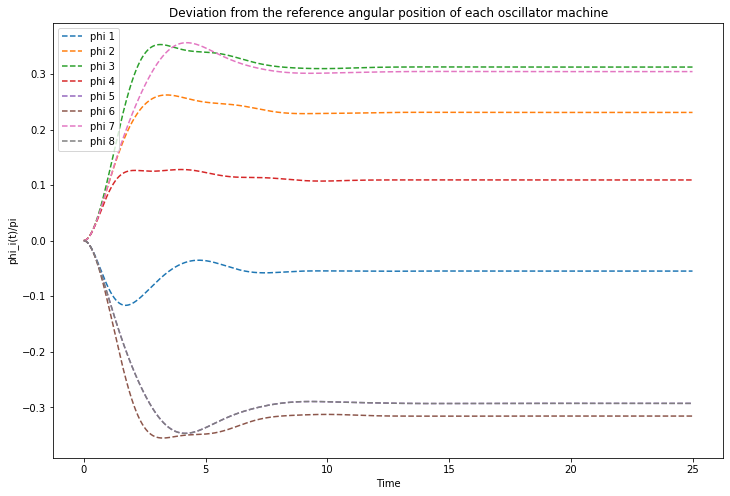

In [6]:
#4. Plotting time domain angular solutions of oscillator network
plt.figure(figsize=(12,8))
plt.plot(t, sol_1[:, 0]/np.pi, '--', label='phi 1')
plt.plot(t, sol_1[:, 1]/np.pi, '--', label='phi 2')
plt.plot(t, sol_1[:, 2]/np.pi, '--', label='phi 3')
plt.plot(t, sol_1[:, 3]/np.pi, '--', label='phi 4')
plt.plot(t, sol_1[:, 4]/np.pi, '--', label='phi 5')
plt.plot(t, sol_1[:, 5]/np.pi, '--', label='phi 6')
plt.plot(t, sol_1[:, 6]/np.pi, '--', label='phi 7')
plt.plot(t, sol_1[:, 7]/np.pi, '--', label='phi 8')

#check rise time
#plt.plot(np.ones(100)*t[rt[7]], np.linspace(-.35, .35, 100) , '--', color='b')
#plt.plot(t, np.ones(len(t))*(sol_1[rt[7],7]/np.pi), '--', color='b')

#check peak time
#plt.plot(np.ones(100)*t[max_index[7]], np.linspace(-.35, .35, 100) , '--', color='b')

#check overshoot
#plt.plot(np.ones(10)*t[max_index[1]], np.linspace(ss[1]/np.pi, max_value[1], 10) , '--', color='b')

#check settling time
#plt.plot(np.ones(100)*t[st[7]], np.linspace(-.35, .35, 100), '--', color='b')

plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('phi_i(t)/pi')
plt.title('Deviation from the reference angular position of each oscillator machine');
#plt.savefig('AngPos_.jpg')
#plt.show()

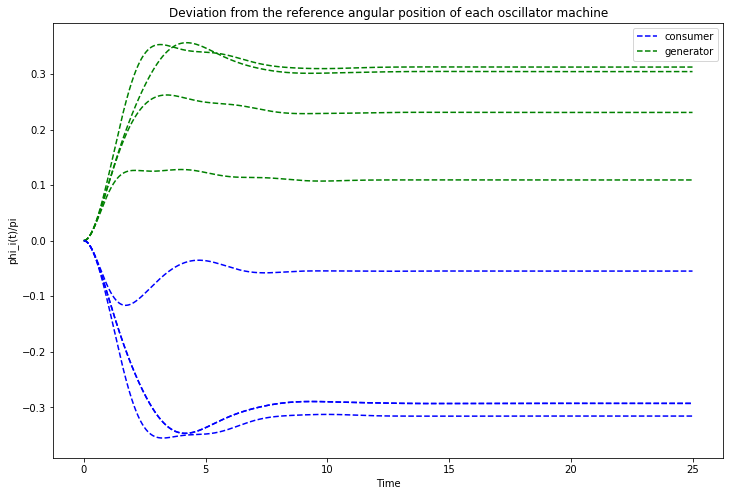

In [7]:
#5. Plotting time domain angular solutions of oscillator network
plt.figure(figsize=(12,8))
plt.plot(t, sol_1[:, 0]/np.pi, '--', color='b', label='consumer')
plt.plot(t, sol_1[:, 1]/np.pi, '--', color='g', label='generator')
plt.plot(t, sol_1[:, 2]/np.pi, '--', color='g')
plt.plot(t, sol_1[:, 3]/np.pi, '--', color='g')
plt.plot(t, sol_1[:, 4]/np.pi, '--', color='b')
plt.plot(t, sol_1[:, 5]/np.pi, '--', color='b')
plt.plot(t, sol_1[:, 6]/np.pi, '--', color='g')
plt.plot(t, sol_1[:, 7]/np.pi, '--', color='b')

plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('phi_i(t)/pi')
plt.title('Deviation from the reference angular position of each oscillator machine');
#plt.savefig('AngPos_4c_5.jpg')
#plt.show()

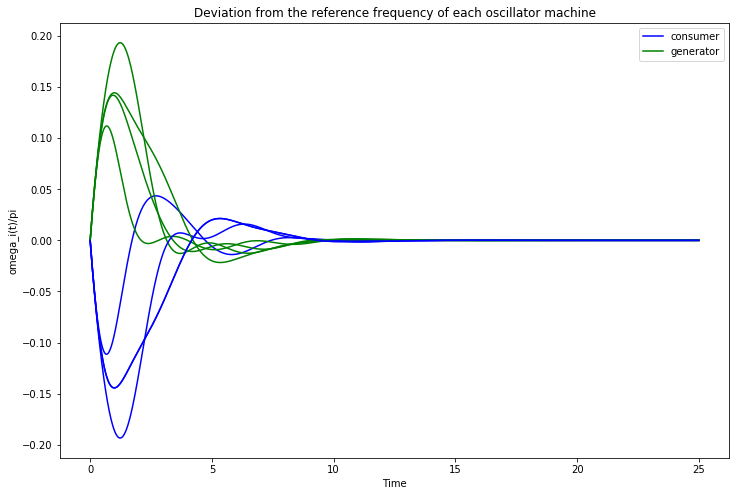

In [8]:
#6. Plotting time domain frequency solutions of oscillator network
#plt.figure(figsize=(12,8))
#plt.plot(t, sol_1[:, 8]/np.pi, '--', label='omega 1')
#plt.plot(t, sol_1[:, 9]/np.pi, '--', label='omega 2')
#plt.plot(t, sol_1[:, 10]/np.pi, '--', label='omega 3')
#plt.plot(t, sol_1[:, 11]/np.pi, '--', label='omega 4')
#plt.plot(t, sol_1[:, 12]/np.pi, '--', label='omega 5')
#plt.plot(t, sol_1[:, 13]/np.pi, '--', label='omega 6')
#plt.plot(t, sol_1[:, 14]/np.pi, '--', label='omega 7')
#plt.plot(t, sol_1[:, 15]/np.pi, '--', label='omega 8')

plt.figure(figsize=(12,8))
plt.plot(t, sol_1[:, 8]/np.pi, color='b', label='consumer')
plt.plot(t, sol_1[:, 9]/np.pi, color='g', label='generator')
plt.plot(t, sol_1[:, 10]/np.pi, color='g')
plt.plot(t, sol_1[:, 11]/np.pi, color='g')
plt.plot(t, sol_1[:, 12]/np.pi, color='b')
plt.plot(t, sol_1[:, 13]/np.pi, color='b')
plt.plot(t, sol_1[:, 14]/np.pi, color='g')
plt.plot(t, sol_1[:, 15]/np.pi, color='b')

#check peak time
#plt.plot(np.ones(100)*t[max_index[11]], np.linspace(-.35, .35, 100) , '--', color='b')

#check settling time
#plt.plot(np.ones(100)*t[st[15]], np.linspace(-.35, .35, 100), '--', color='b')

plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('omega_i(t)/pi')
plt.title('Deviation from the reference frequency of each oscillator machine');
#plt.savefig('Freq_4c_5.jpg')
#plt.show()

In [9]:
#7. Exporting data to CSV
df = pd.DataFrame({'Time': t,
                   'Phi 1': sol_1[:,0], 'Phi 2': sol_1[:,1], 'Phi 3': sol_1[:,2], 'Phi 4': sol_1[:,3],
                   'Phi 5': sol_1[:,4], 'Phi 6': sol_1[:,5], 'Phi 7': sol_1[:,6], 'Phi 8': sol_1[:,7],
                   'Omega 1': sol_1[:,8], 'Omega 2': sol_1[:,9], 'Omega 3': sol_1[:,10], 'Omega 4': sol_1[:,11],
                   'Omega 5': sol_1[:,12], 'Omega 6': sol_1[:,13], 'Omega 7': sol_1[:,14], 'Omega 8': sol_1[:,15]})
#df.to_excel('oscillator_data.xlsx', sheet_name='sheet1', index=False)

In [252]:
#PART 2- PERFORMANCE SPECIFICATION

In [253]:
#1. Rise Time- elapsed time before initially crossing steady state value
ss = sol_1[len(t)-1,:]
rt = np.asarray([0]*16)
for j in range(16):
    for i in range(len(t)):
        if np.absolute(sol_1[i,j]/np.pi-ss[j]/np.pi) < 10**-3.5:
            rt[j] = i
            break
rt

array([54878, 95204, 99984, 87214, 99993, 96501, 99992, 99993, 48741,
       99963,  1211,  1839, 41109, 99499, 49072, 41109])

In [254]:
#value of maximum rise time and which signal it occurs
print(t[rt[np.argmax(rt)]])
print(np.argmax(rt)+1)

24.99849998499985
5


In [255]:
#2. Peak Time- Elapsed time before reaching max value
max_index = np.asarray([0]*16)
max_value = np.asarray([.0]*16)
for j in range(16):
    max_index[j] = np.argmax(np.absolute(sol_1[:,j]))
    max_value[j] = np.max(np.absolute(sol_1[:,j]/np.pi))
print(max_index, "\n")
print(max_value)

[68836 97339 99999 88609 99999 97958 99999 99999 64337 90114 68323 65522
 65911 67965 63947 65911] 

[0.52119636 3.00094451 2.96309205 2.81930937 3.91913074 4.00826897
 2.8861333  3.91913074 0.5291773  0.37030257 0.47135488 0.66095382
 0.41189286 0.50246799 0.41292007 0.41189286]


In [256]:
#value of maximum peak time and which signal it occurs
print(t[max_index[np.argmax(max_index)]])
print(np.argmax(max_index)+1)

25.0
3


In [257]:
#3. Overshoot- Difference between steady state value and max value
os = np.asarray([.0]*16)
for j in range(16):
    os[j] = np.absolute(ss[j]/np.pi-sol_1[max_index[j],j]/np.pi)
os #value of overshoot for each signal

array([0.74622775, 0.03040849, 0.        , 0.03762365, 0.        ,
       0.02005196, 0.        , 0.        , 0.59849699, 0.44477132,
       0.38796553, 0.55946132, 0.21251947, 0.55719665, 0.24863473,
       0.21251947])

In [258]:
#value of maximum overshoot and which signal it occurs
print(np.max(os))
print(np.argmax(os)+1)

0.7462277465319367
1


In [259]:
#4. Settling Time- time taken to stay within delta of steady state value
delta = 10**-3
st = np.asarray([0]*16)
st_index = np.asarray([np.inf]*len(t))

for j in range(16):
    for i in range(len(t)):
        if(np.absolute(ss[j]/np.pi-sol_1[i,j]/np.pi) < delta):
            st_index[i] = 0

    for k in range(len(st_index)):
        if(st_index[k] == np.inf):
            st[j] = k
            
st

array([99941, 99941, 99941, 99941, 99941, 99926, 99926, 99926, 99926,
       99889, 99604, 99604, 99604, 99429, 99429, 99429])

In [260]:
#value of maximum settling time and which signal it occurs
print(t[st[np.argmax(st)]])
print(np.argmax(st)+1)

24.985499854998547
1


In [10]:
#PART 3- STABILITY ANALYSIS AROUND FIXED POINT

In [11]:
#1. Defining system of equations to find fixed point
def func(X, K, C, P, alpha):
    
    # i = node under consideration
    # j = coupled node
    
    # preallocating vectors
    coupling = np.zeros((8,1))
    
    # calculating coupling term of each omega equation
    for a in range(len(coupling)):
        for b in range(len(coupling)):
            coupling[a] = coupling[a] + K[a,b]*np.sin(X[b]-X[a])

    # phi_0, ..., phi_7, omega_0, ..., omega_7  = X #unpacking state vector
    Y = [.0]*16 # list of equations
    
    # system of equations to be solved
    Y[0] = X[8]
    Y[1] = X[9]
    Y[2] = X[10]
    Y[3] = X[11]
    Y[4] = X[12]
    Y[5] = X[13]
    Y[6] = X[14]
    Y[7] = X[15]
    Y[8] =  P[0] + coupling[0] - alpha[0]*X[8]  - C[0]*X[0]   
    Y[9] =  P[1] + coupling[1] - alpha[1]*X[9]  - C[1]*X[1]   
    Y[10] = P[2] + coupling[2] - alpha[2]*X[10] - C[2]*X[2]   
    Y[11] = P[3] + coupling[3] - alpha[3]*X[11] - C[3]*X[3]   
    Y[12] = P[4] + coupling[4] - alpha[4]*X[12] - C[4]*X[4]   
    Y[13] = P[5] + coupling[5] - alpha[5]*X[13] - C[5]*X[5]   
    Y[14] = P[6] + coupling[6] - alpha[6]*X[14] - C[6]*X[6]   
    Y[15] = P[7] + coupling[7] - alpha[7]*X[15] - C[7]*X[7]       
    
    return Y

In [12]:
#2. Solving equations to find fixed points
init = [.0]*16
init[0:8] = [.4]*8
fp = root(func, init, method='lm', args=(K,C,P,alpha)) # finding fixed point of system of equations
fixed_point = fp.x
message = fp.message # describes cause of algo termination
success = fp.success # Boolean flag indicating if the algorithm exited successfully
print("Fixed point:\n",fixed_point,"\n")
print("Message: ", message)
print("Success: ", success)
# method='lm',
# different methods and initial conditions find different fixed points. All fixed points have the frequency as zero and
# varying phases. This is as expected from the analytical analysis

Fixed point:
 [-1.72280660e-01  7.24984081e-01  9.81652075e-01  3.43043005e-01
 -9.20556999e-01 -9.92304330e-01  9.56019826e-01 -9.20556999e-01
  8.73545450e-28  4.33741414e-27  2.35979465e-27 -2.29622248e-27
  2.14674709e-28  1.64281949e-27 -3.88451738e-28 -1.46932590e-27] 

Message:  The relative error between two consecutive iterates is at most 0.000000
Success:  True


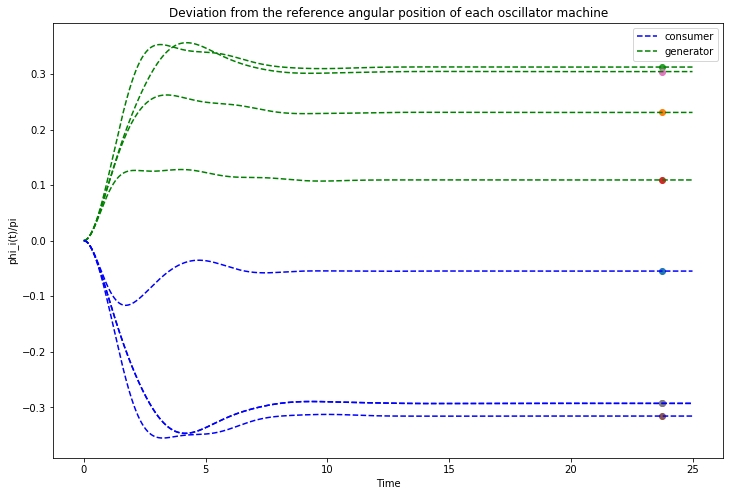

In [13]:
#3. Plotting fixed point against phase dynamics
plt.figure(figsize=(12,8))
plt.plot(t, sol_1[:, 0]/np.pi, '--', color='b', label='consumer')
plt.plot(t, sol_1[:, 1]/np.pi, '--', color='g', label='generator')
plt.plot(t, sol_1[:, 2]/np.pi, '--', color='g')
plt.plot(t, sol_1[:, 3]/np.pi, '--', color='g')
plt.plot(t, sol_1[:, 4]/np.pi, '--', color='b')
plt.plot(t, sol_1[:, 5]/np.pi, '--', color='b')
plt.plot(t, sol_1[:, 6]/np.pi, '--', color='g')
plt.plot(t, sol_1[:, 7]/np.pi, '--', color='b')

plt.scatter(t[95000], fixed_point[0]/np.pi)
plt.scatter(t[95000], fixed_point[1]/np.pi)
plt.scatter(t[95000], fixed_point[2]/np.pi)
plt.scatter(t[95000], fixed_point[3]/np.pi)
plt.scatter(t[95000], fixed_point[4]/np.pi)
plt.scatter(t[95000], fixed_point[5]/np.pi)
plt.scatter(t[95000], fixed_point[6]/np.pi)
plt.scatter(t[95000], fixed_point[7]/np.pi)

plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('phi_i(t)/pi')
plt.title('Deviation from the reference angular position of each oscillator machine');
#plt.savefig('AngPos_4c_5.jpg')
#plt.show()

In [14]:
#4. Computing system dynamics starting from the fixed point
x0 = fixed_point
t = np.linspace(0, 25, 1000) #time span
sol_2 = odeint(oscillator_model, x0, t, args=(K,C,P,alpha)) #solver

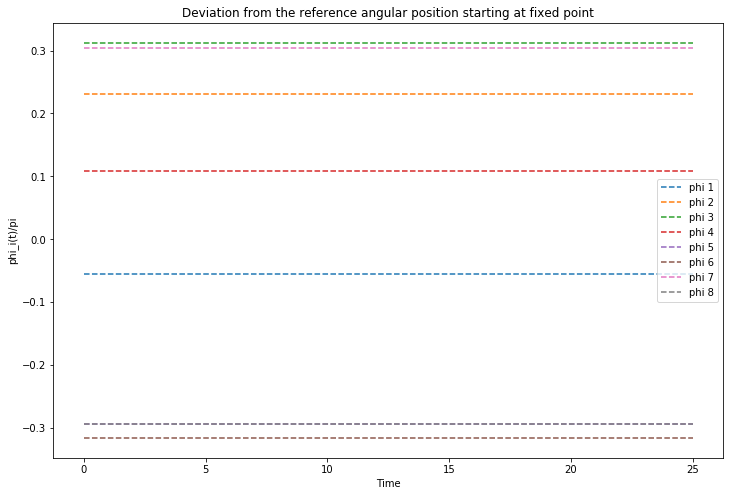

In [15]:
#5. Plotting time domain angular solutions of oscillator network starting from fixed point
plt.figure(figsize=(12,8))
plt.plot(t, sol_2[:, 0]/np.pi, '--', label='phi 1')
plt.plot(t, sol_2[:, 1]/np.pi, '--', label='phi 2')
plt.plot(t, sol_2[:, 2]/np.pi, '--', label='phi 3')
plt.plot(t, sol_2[:, 3]/np.pi, '--', label='phi 4')
plt.plot(t, sol_2[:, 4]/np.pi, '--', label='phi 5')
plt.plot(t, sol_2[:, 5]/np.pi, '--', label='phi 6')
plt.plot(t, sol_2[:, 6]/np.pi, '--', label='phi 7')
plt.plot(t, sol_2[:, 7]/np.pi, '--', label='phi 8')

plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('phi_i(t)/pi')
plt.title('Deviation from the reference angular position starting at fixed point');
#plt.savefig('AngPos_4c_fp.jpg')
#plt.show()

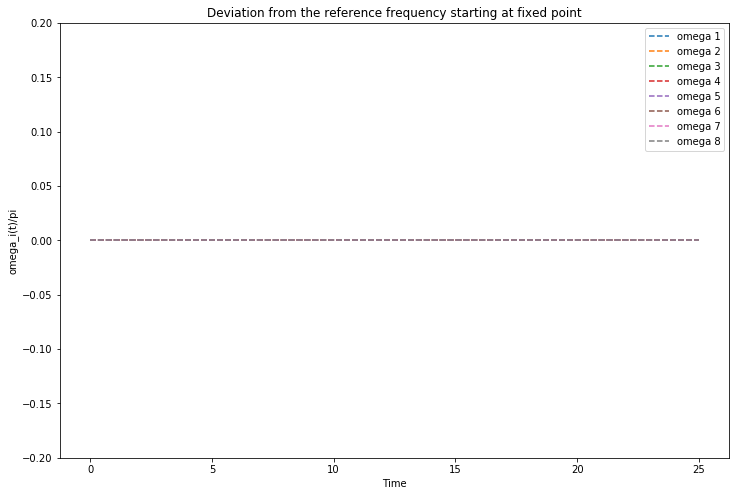

In [16]:
#6. Plotting time domain frequency solutions of oscillator network starting from fixed point
plt.figure(figsize=(12,8))
plt.ylim((-.2,.2))
plt.plot(t, sol_2[:, 8]/np.pi, '--', label='omega 1')
plt.plot(t, sol_2[:, 9]/np.pi, '--', label='omega 2')
plt.plot(t, sol_2[:, 10]/np.pi, '--', label='omega 3')
plt.plot(t, sol_2[:, 11]/np.pi, '--', label='omega 4')
plt.plot(t, sol_2[:, 12]/np.pi, '--', label='omega 5')
plt.plot(t, sol_2[:, 13]/np.pi, '--', label='omega 6')
plt.plot(t, sol_2[:, 14]/np.pi, '--', label='omega 7')
plt.plot(t, sol_2[:, 15]/np.pi, '--', label='omega 8')


plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('omega_i(t)/pi')
plt.title('Deviation from the reference frequency starting at fixed point');
#plt.savefig('Freq_4c_fp.jpg')
#plt.show()

In [17]:
#4.Linearizing system around fixed point
def ss_analysis(x, t, K, C, alpha, fp):

    # i = node under consideration
    # j = coupled node
    
    # preallocating Laplacian matrix
    L = np.zeros((K.shape[0],K.shape[1]))
    
    # calculating each Laplacian term
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):
            if i!=j:
                L[i,j] = -K[i,j]*np.cos(fp[i] - fp[j])
            else:
                for k in range(L.shape[1]):
                    if k==i:
                        continue
                    L[i,j] = L[i,j] + K[i,k]*np.cos(fp[i] - fp[k])
    
    # converting system of equations into matrix form
    zero = np.zeros((8,8))
    one = np.eye(8)
    A = alpha*np.eye(8) # damping matrix- parameter is same for all nodes
    C = C*np.eye(8) # control matrix- parameter is same for all nodes
    
    # joining matrices into one large system
    J1 = np.concatenate((zero, -L-C))
    J2 = np.concatenate((one, -A))
    J = np.concatenate((J1, J2), axis=1)
    
    # system of equations to be solved
    dxdt =  np.matmul(J,x)
    
    return dxdt

In [18]:
#5. Use a package to solve the differential equation for 25 time units
x0 = [.0]*16
x0[0], x0[2], x0[12] = [-.03, .05, .010]
t = np.linspace(0, 25, 1000) #time span
fp_tup = tuple(fixed_point)
sol_3 = odeint(ss_analysis, x0, t, args=(K,C,alpha,fp_tup,)) #solver

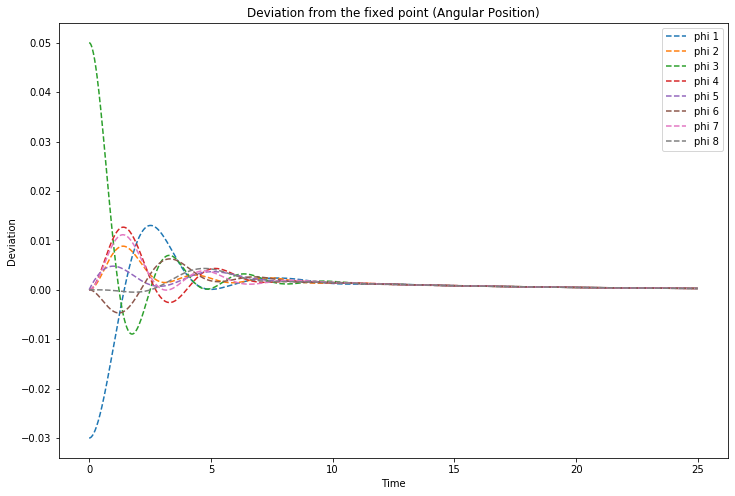

In [19]:
#6. Plotting deviations from fixed point (angular position states)
plt.figure(figsize=(12,8))
plt.plot(t, sol_3[:, 0], '--', label='phi 1')
plt.plot(t, sol_3[:, 1], '--', label='phi 2')
plt.plot(t, sol_3[:, 2], '--', label='phi 3')
plt.plot(t, sol_3[:, 3], '--', label='phi 4')
plt.plot(t, sol_3[:, 4], '--', label='phi 5')
plt.plot(t, sol_3[:, 5], '--', label='phi 6')
plt.plot(t, sol_3[:, 6], '--', label='phi 7')
plt.plot(t, sol_3[:, 7], '--', label='phi 8')

plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Deviation')
plt.title('Deviation from the fixed point (Angular Position)');
#plt.savefig('Freq.jpg')
#plt.show()

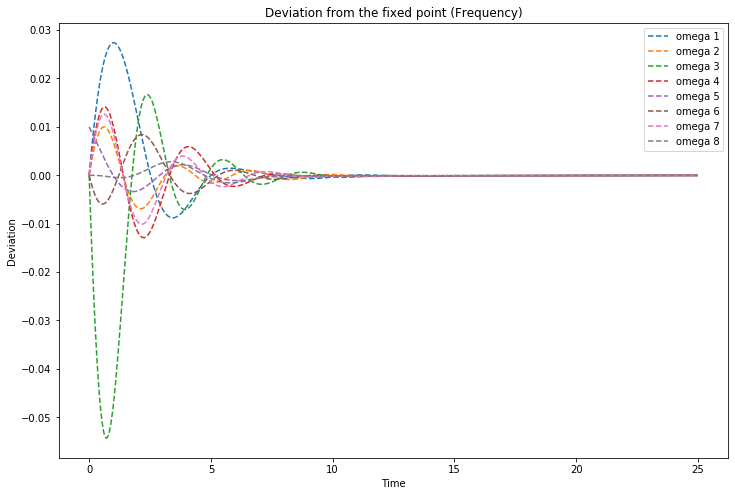

In [20]:
#7. Plotting deviations from fixed point (frequency states)
plt.figure(figsize=(12,8))
plt.plot(t, sol_3[:, 8], '--', label='omega 1')
plt.plot(t, sol_3[:, 9], '--', label='omega 2')
plt.plot(t, sol_3[:, 10], '--', label='omega 3')
plt.plot(t, sol_3[:, 11], '--', label='omega 4')
plt.plot(t, sol_3[:, 12], '--', label='omega 5')
plt.plot(t, sol_3[:, 13], '--', label='omega 6')
plt.plot(t, sol_3[:, 14], '--', label='omega 7')
plt.plot(t, sol_3[:, 15], '--', label='omega 8')

plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Deviation')
plt.title('Deviation from the fixed point (Frequency)');
#plt.savefig('Freq.jpg')
#plt.show()

In [21]:
#8. Finds eigenvalues of the Laplacian and Jacobian. Returns ordered arrays with imaginary component removed
def find_eigs(K, C, alpha, fp):

    # i = node under consideration
    # j = coupled node
    
    # preallocating vectors
    L = np.zeros((8,8)) # Laplacian
    
    # calculating each Laplacian term
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):
            if i!=j:
                L[i,j] = -K[i,j]*np.cos(fp[i] - fp[j])
            else:
                for k in range(L.shape[1]):
                    if k==i:
                        continue
                    L[i,j] = L[i,j] + K[i,k]*np.cos(fp[i] - fp[k])
    
    # converting system of equations into matrix form
    zero = np.zeros((8,8))
    one = np.eye(8)
    A = alpha*np.eye(8) # damping parameter is same for all nodes
    C = C*np.eye(8) # control matrix- parameter is same for all nodes
    
    # joining matrices into one large system
    J1 = np.concatenate((zero, -L-C))
    J2 = np.concatenate((one, -A))
    J = np.concatenate((J1, J2), axis=1)
    
    # computing eigenvalues
    eig_L = np.linalg.eig(L)
    eig_J = np.linalg.eig(J)
    
    # extracting eigenvalues
    eig_L = eig_L[0]
    eig_J = eig_J[0]
    
    # converting to numpy arrays
    eig_L = np.asarray(eig_L)
    eig_J = np.asarray(eig_J)
    
    # sorting laplacian eigenvalues into ascending order
    eig_L.sort()
    
    # removing imaginary component and sorting, only order of eigenvalues without imaginary component matters
    # the linked eigenvalues without imaginary components will be at opposite ends of the array 
    eig_J = eig_J.real
    eig_J.sort()
    
    # splitting array into two and reordering the second part of the array such that the same index maps to the same
    # Laplacian eigenvalue
    eig_J1 = eig_J[0:L.shape[0]]
    eig_J2 = eig_J[L.shape[0+1]:len(eig_J)]
    eig_J2 = sorted(eig_J2,reverse=True)
    
    # combining into one nx2 matrix
    eig_J = np.asarray([eig_J1, eig_J2])
    
    return eig_L, eig_J

In [22]:
#9. Storing eigenvalues of laplacian and jacobian
eig_L_comp, eig_J_comp = find_eigs(K, C, alpha, fixed_point)

print("Eigenvalues of Laplacian:\n", eig_L_comp, "\n")
print("Eigenvalues of Jacobian:\n", eig_J_comp, "\n")

Eigenvalues of Laplacian:
 [4.44089210e-16 5.41662352e-01 1.33880911e+00 1.45890596e+00
 1.73149971e+00 3.50843842e+00 3.80388088e+00 4.16181920e+00] 

Eigenvalues of Jacobian:
 [[-0.88729833 -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5       ]
 [-0.11270167 -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5       ]] 



In [23]:
#11. Function for computing real part of eiq_J as a function of eig_L
def calc_eig(eig_L, c, alpha):
    J_plus = -0.5*alpha + 0.5*cmath.sqrt(alpha**2 -4*(eig_L+c))
    J_minus = -0.5*alpha - 0.5*cmath.sqrt(alpha**2 -4*(eig_L+c))
    return [J_plus.real, J_minus.real]

In [24]:
#12. Computing real part of eiq_J as a function of eig_L
eig_L_calc = np.linspace(-1,1,500)
eig_J_calc = [.0]*len(eig_L_calc)
for i in range(len(eig_L_calc)):
    eig_J_calc[i] = calc_eig(eig_L_calc[i], C[0], alpha[0]) #**only works when c and alpha are uniform
eig_J_calc = np.asarray(eig_J_calc)

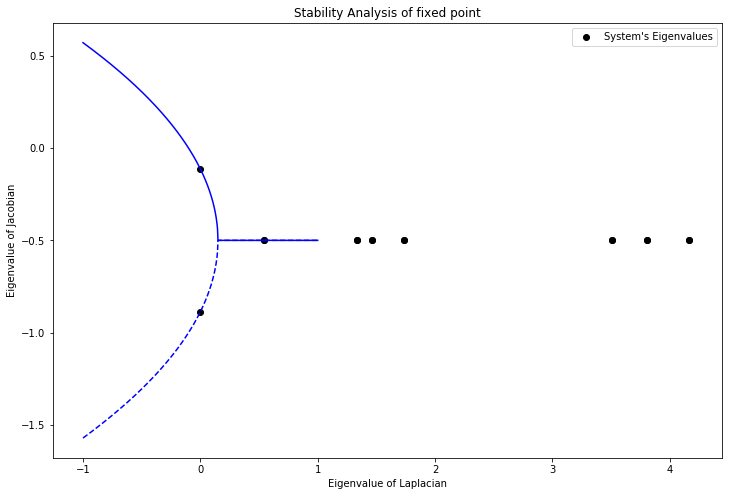

In [25]:
#13. Plotting eiq_J as a function of eig_L
plt.figure(figsize=(12,8))
#plt_zero = eig_L_calc[80:105]
#plt.plot(plt_zero, np.zeros(len(plt_zero)), '--', color='r')
#plt.plot(np.zeros(len(eig_L_calc)),np.linspace(-1.6, .6, len(eig_L_calc)) , '--', color='r')
plt.plot(eig_L_calc, eig_J_calc[:,0], color='b')
plt.plot(eig_L_calc, eig_J_calc[:,1], '--', color='b')
plt.scatter(eig_L_comp, eig_J_comp[0], color='k', label="System's Eigenvalues")
plt.scatter(eig_L_comp, eig_J_comp[1], color='k')

#plt.text(.35, -.25, r'Stable Region', fontsize=13)
#plt.text(-1.1, -.25, r'Unstable Region', fontsize=13)
plt.legend(loc='best')
plt.xlabel('Eigenvalue of Laplacian')
plt.ylabel('Eigenvalue of Jacobian')
plt.title('Stability Analysis of fixed point');
#plt.savefig('Eigenvals_4c.jpg')
#plt.show()